In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from astropy.table import Table
from tqdm import tqdm
from jax.ops import index_update
import scipy

rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('400_BCE_Data_processed.csv', time_oversample=50)
cf.prepare_function(use_control_points=True, gap_years=4)

In [3]:
cf.control_points_time

DeviceArray([-427., -426., -422., -418., -414., -410., -406., -402.,
             -398., -394., -390., -386., -382., -375., -370., -365.,
             -360., -356., -352., -348., -344., -340., -336., -332.,
             -328.], dtype=float64)

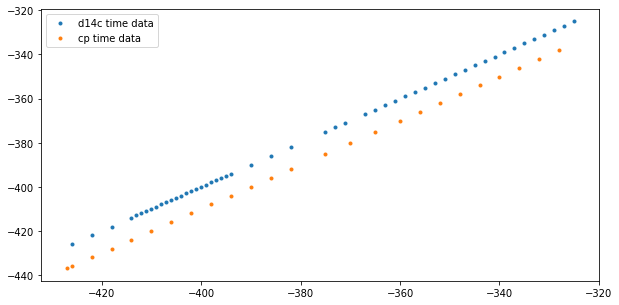

In [4]:
plt.plot(cf.time_data, cf.time_data, ".", label="d14c time data")
plt.plot(cf.control_points_time, cf.control_points_time -10, ".", label="cp time data")
plt.legend()

In [5]:
steady_state = cf.steady_state_production * jnp.ones((len(cf.control_points_time),))
params = steady_state
bounds = tuple([(0, None)] * len(steady_state))

In [6]:
params.shape

(25,)

In [7]:
%%time
soln = cf.fit_cp(low_bound=0, avg=True, k=2)

CPU times: user 14.1 s, sys: 31.2 ms, total: 14.1 s
Wall time: 14.2 s


In [8]:
soln.message

'ABNORMAL_TERMINATION_IN_LNSRCH'

In [9]:
cf.loss_chi2(params=soln.x)

DeviceArray(8.62694595, dtype=float64)

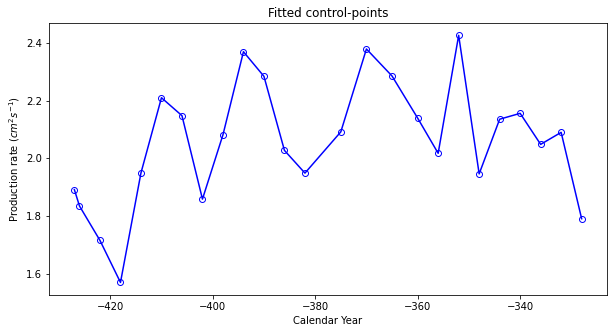

In [10]:
plt.plot(cf.control_points_time, soln.x, "ob", fillstyle="none")
plt.plot(cf.control_points_time, soln.x, "b")
plt.ylabel("Production rate ($cm^2s^{-1}$)");
plt.xlabel("Calendar Year");
plt.title(r"Fitted control-points");

In [11]:
fine = cf.dc14_fine(params=soln.x)
coarse = cf.dc14(params=soln.x)

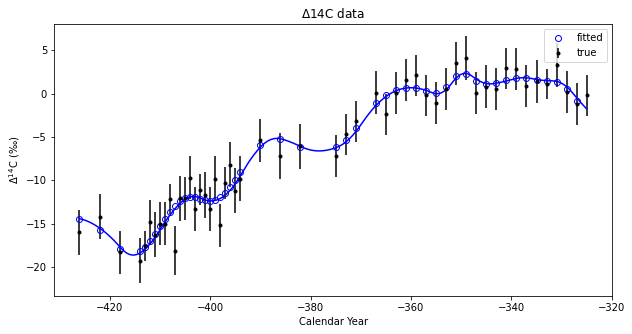

In [12]:
plt.plot(cf.time_grid_fine, fine, "b")
plt.plot(cf.time_data[:-1], coarse, "ob", fillstyle="none", label="fitted")
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt=".k", label="true")
plt.legend()
plt.ylabel("$\Delta^{14}$C (‰)")
plt.xlabel("Calendar Year");
plt.title("$\Delta$14C data");

In [13]:
soln.x

array([1.89095997, 1.83417199, 1.71467775, 1.569081  , 1.94902596,
       2.20969282, 2.14745389, 1.85809515, 2.0811377 , 2.36924955,
       2.28385801, 2.02703719, 1.94831993, 2.0913343 , 2.3787631 ,
       2.28493719, 2.13892236, 2.01699076, 2.42601084, 1.9455935 ,
       2.13520437, 2.15553607, 2.04797596, 2.08958722, 1.79017299])

In [14]:
fine = cf.dc14_fine(params=soln.x)